In [1]:
# PyTorch
import torch
from torch.utils.data import random_split
# PyG
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# PyTorch-Lightning
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
# NetworkX
import networkx as nx
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# Local
from GNN import GNN_model, SchNet
from kan_schnet import SchNetspec
from dataset import XASMolDataset, SchNetDataset
from utils.functions import count_funct_groups

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')
print(f'Lightning version: {L.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3
Lightning version: 2.4.0


In [3]:
# --- Path raw directory containing the data
path = "../"
# dataset = XASMolDataset(path)
dataset = SchNetDataset(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)

SchNetDataset(317)
------------
Number of graphs: 317
Number of features: 3
Number of classes: 0

Data(x=[43, 3], z=[43], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')


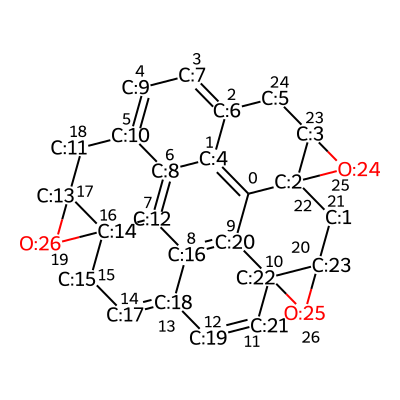

In [5]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

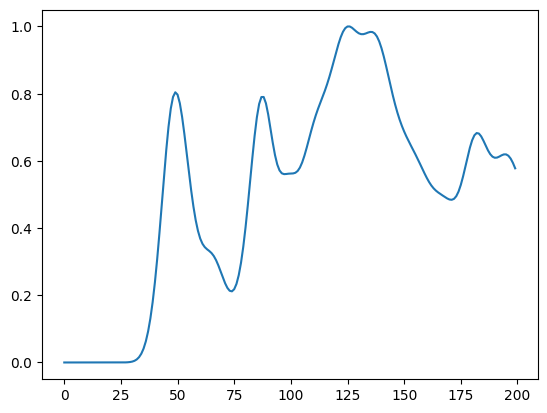

In [6]:
# Show molecule spectrum
plt.plot(data.spectrum)
plt.show()

In [7]:
# Random seed to reproduce data split
generator = torch.Generator().manual_seed(222)
# Split dataset into train, validation and test sets
train_data, val_data, test_data = random_split(dataset, [0.75, 0.125, 0.125], generator)

print(f'Length of training data: {len(train_data)}')
print(f'Length of validation data: {len(val_data)}')
print(f'Length of testing data: {len(test_data)}')

# torch.save(test_data, './processed/test_data_coronene.pt')

Length of training data: 238
Length of validation data: 40
Length of testing data: 39


In [8]:
# Load data splits into DataLoaders
# train_data = dataset[0:1]

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=39, shuffle=False)

print(f'Number of batches in train loader: {len(train_loader)}')
print(f'Number of batches in val loader: {len(val_loader)}')

Number of batches in train loader: 238
Number of batches in val loader: 1


In [172]:
model = SchNet(hidden_channels=2, num_filters=200, num_interactions=6,
               num_gaussians=50, cutoff=10.0)
# model = SchNetspec(hidden_channels=300, num_filters=200, num_interactions=6,
                #    num_gaussians=50, cutoff=10.0)
print(model)

SchNet(hidden_channels=2, num_filters=200, num_interactions=6, num_gaussians=50, cutoff=10.0)


In [173]:
import torch.nn as nn

def train_schnet(model, train_loader, optimizer, device, criterion):

    model.train()

    total_loss = 0
    num_graphs = 0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()

        pred = model(batch.z, batch.x, batch.batch)

        loss = nn.MSELoss()(pred.flatten(), batch.spectrum)

        total_loss += loss.item() * batch.num_graphs
        num_graphs += batch.num_graphs

        loss.backward()

        optimizer.step()

    return total_loss

def val_schnet(model, val_loader, device):
    '''
    '''

    model.eval()
   
    total_loss = 0
    num_graphs = 0

    for batch in val_loader:
        batch = batch.to(device)

        pred = model(batch.z, batch.x, batch.batch)

        loss = nn.MSELoss()(pred.flatten(), batch.spectrum)

        total_loss += loss.item()
        num_graphs = batch.num_graphs

    return total_loss / num_graphs

In [174]:
# --- Set model optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
# --- Set optimizer scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)
# --- Select device to run model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()

In [240]:
data = train_loader.dataset[0].to(device)

optimizer.zero_grad()

pred = model(data.z, data.x, data.batch)
spec = data.spectrum.detach().cpu().numpy()


In [241]:
pred.shape

torch.Size([1, 200])

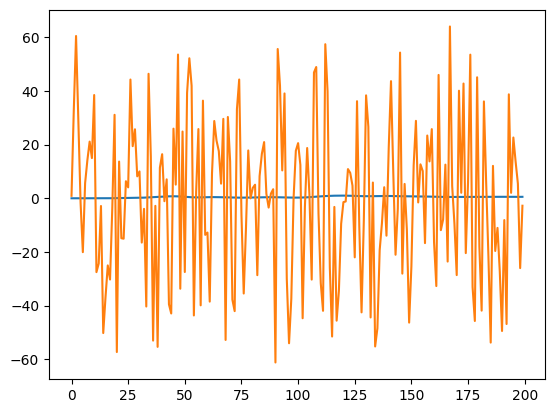

In [242]:
plt.plot(spec)
plt.plot(pred.flatten().detach().cpu().numpy())
plt.show()

In [243]:
loss = nn.MSELoss()(pred.flatten(), data.spectrum)
print(loss)

tensor(879.7142, device='cuda:0', grad_fn=<MseLossBackward0>)


In [244]:
loss.backward()
optimizer.step()

In [12]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    loss = train_schnet(model, train_loader, optimizer, device, criterion) / (len(train_data))

    val_error = val_schnet(model, val_loader, device)

    scheduler.step(val_error)

    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]['lr']

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:.3f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}')

Epoch: 000, LR: 0.010, TrainLoss: 903.13275, ValLoss: 3984.79219
Epoch: 001, LR: 0.010, TrainLoss: 170172.43750, ValLoss: 24107.47344
Epoch: 002, LR: 0.010, TrainLoss: 1032012.18750, ValLoss: 606617.75000
Epoch: 003, LR: 0.010, TrainLoss: 25856998.00000, ValLoss: 7464400486.40000
Epoch: 004, LR: 0.010, TrainLoss: 327710703616.00000, ValLoss: 3270790.00000
Epoch: 005, LR: 0.010, TrainLoss: 144608528.00000, ValLoss: 108366161510.39999
Epoch: 006, LR: 0.010, TrainLoss: 4815869444096.00000, ValLoss: 115676.27500
Epoch: 007, LR: 0.010, TrainLoss: 5254550.50000, ValLoss: 40311196.80000
Epoch: 008, LR: 0.010, TrainLoss: 1748886656.00000, ValLoss: 116053107.20000
Epoch: 009, LR: 0.010, TrainLoss: 4996536832.00000, ValLoss: 5285595136.00000


#### Training

In [13]:
# Seed for reproducibility
L.seed_everything(1994, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision('high')

Seed set to 1994


In [14]:
checkpoint_callback = ModelCheckpoint(
    filename='{val_loss:.6f}-{epoch:02d}',
    monitor='val_loss',
    mode='min',
    save_top_k=10
)

lr_monitor = LearningRateMonitor(logging_interval='step')

In [15]:
path = './'
logger = L.pytorch.loggers.TensorBoardLogger(save_dir=path, default_hp_metric='val_loss')
# Lightning trainer
trainer = L.Trainer(logger=logger,
                    callbacks=[checkpoint_callback, lr_monitor],
                    default_root_dir=path,
                    max_epochs=50, 
                    accelerator='auto',
                    log_every_n_steps=1,
                    deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, train_loader, val_loader)

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `SchNetspec`

In [ ]:
test = trainer.test(model, test_loader, ckpt_path='best')

Restoring states from the checkpoint path at ./lightning_logs/version_1/checkpoints/val_loss=9801099.000000-epoch=33.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/version_1/checkpoints/val_loss=9801099.000000-epoch=33.ckpt
/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/samjhall/github/GNN-XAS-GO/PyG_models/GNN.py:504: UserWarning: Using a target size (torch.Size([39, 200])) that is different to the input size (torch.Size([1, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, data.spectrum)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MSE          │         9427564.0         │
│         test_RSE          │    227.42149353027344     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
results = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results

[(array([[-1.8648722e+03, -1.3016388e+03,  1.8045259e+02,  1.7913525e+03,
           1.2185249e+03, -1.8134012e+03,  5.2628281e+03,  2.4202065e+03,
          -4.8250613e+02,  2.7340166e+03,  4.5050410e+03, -9.3885596e+02,
          -2.4554152e+02, -2.6033508e+03, -7.9665894e+02, -5.9718379e+03,
          -2.4351772e+03, -1.1413359e+03, -6.2803799e+03,  2.4752332e+03,
           2.4850696e+03, -7.7929312e+03,  3.8976982e+03, -1.1019872e+03,
           7.6618121e+02, -1.9429012e+03, -5.2501575e+02,  1.9738535e+03,
          -7.3350527e+03, -3.5925308e+02, -5.7412485e+03, -5.5872119e+02,
          -1.0372660e+03,  2.3074570e+03, -2.1013203e+03,  1.4539760e+03,
          -2.5352266e+03, -4.5336533e+03, -3.7981174e+03,  2.4482234e+03,
           1.6776183e+03,  2.1967566e+03, -1.0407783e+03, -2.0538757e+03,
          -2.7816255e+03,  5.0222417e+03, -4.0591299e+03, -1.0059288e+03,
           1.5457568e+03,  2.9750090e+03, -1.8078943e+03,  4.3710181e+03,
           3.1644014e+03, -4.5968032e+

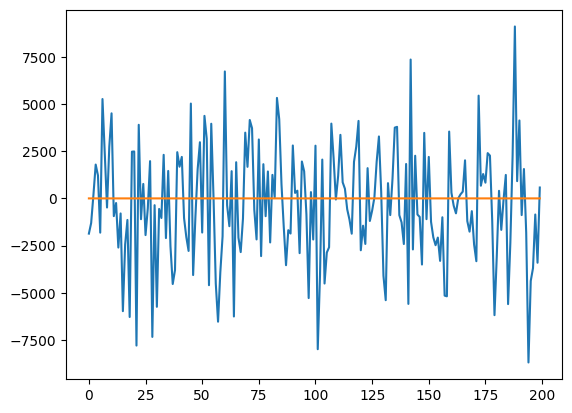

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results[0][0][0])
plt.plot(results[0][1][0])
plt.show()

In [ ]:
import numpy as np
def calculate_rse(prediction, true_result):
    
    del_E = 20 / len(prediction)

    numerator = np.sum(del_E * np.power((true_result - prediction),2))

    denominator = np.sum(del_E * true_result)

    return np.sqrt(numerator) / denominator

In [ ]:
from utils.functions import RSE_loss
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(results[0][0][0], results[0][1][0])

rse = calculate_rse(results[0][0][0], results[0][1][0])

In [ ]:
mse

np.float32(591150850.0)

In [ ]:
rse

np.float32(11029.13)

In [ ]:
len(results[0][0])

1

In [ ]:
rse_values = []
mse_values = []

for x in range(len(results[0][0])):
    rse = calculate_rse(results[0][0][x], results[0][1][x])
    mse = mean_squared_error(results[0][0][x], results[0][1][x])
    rse_values.append(float(rse))
    mse_values.append(mse)

In [ ]:
rse_values

[11029.1298828125]

In [ ]:
print(rse_values.index(min(rse_values)))
print(mse_values.index(min(mse_values)))

0
0


In [ ]:
min(rse_values)

11029.1298828125

In [ ]:
sum(rse_values) / len(rse_values)

11029.1298828125

In [ ]:
sum(mse_values) / len(mse_values)

np.float32(591150850.0)